In the following cell, we import Telco dataset and store it in a dataframe

In [ ]:
df = pd.read_csv("/Users/Tanya/cleaned_Telco.csv")

## Set the Churn Column as Output and the Others as Inputs

In [6]:
X = df.loc[ : , df.columns != 'Churn']
y = df.loc[ : , df.columns == 'Churn']

## Using kmeans to cluster data

In [7]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.cluster import KMeans
import math

km = KMeans(
    n_clusters=55, init='k-means++',
    n_init=10, max_iter=10000000,
    tol=1e-04, random_state=42
)

y_km = km.fit_predict(X)

### Adding the cluster to data as a new column

In [8]:
X['Cluster'] = y_km.reshape(-1,1)

# Splitting the Data into Training and Testing Dataset and Normalizing Them

The data seems to be imbalanced. The data with 'No' or 0 label is 73.4% of all data, whereas sata with 'yes' or 1 label only consists 26.6% of data. Therefore we should stratify the data on labels. <br/>

This `stratify` parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter `stratify`. <br/><br/>
P.S. In the upcoming models, we will also use Stratified K-Fold cross validation to better analyze the model and prediction accuracy. Therefore the use of stratify is not mandatory in `train_test_split`, but for better coding we will still take it into account, as the data is imbalanced.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)   

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Plotting
The function below is used to plot the ROC Curve in the Models

In [10]:
def plot_sklearn_roc_curve(y_real, y_pred, title):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color = 'g')

# Model 1: Random Forest Classifier
In the first model, we will use Random Forest with `n_estimators` and `max_depth` as our parameters.

Train F1-Score: 0.7617354196301563
Test F1-Score: 0.5909752547307132


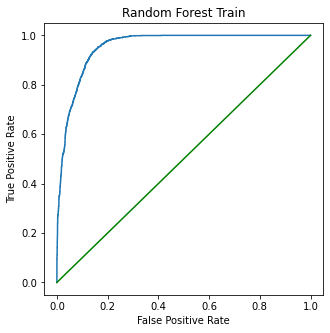

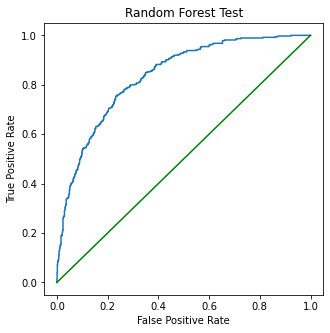

In [11]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(n_estimators=50, max_depth = 10, random_state = 42)

mdl.fit(X_train, y_train.values.ravel())
ypred_train_rf = mdl.predict(X_train)
y_pred_test_rf = mdl.predict(X_test)

y_proba_train_rf = mdl.predict_proba(X_train)
y_proba_test_rf = mdl.predict_proba(X_test)

print('Train F1-Score:', f1_score(y_train, ypred_train_rf))
print('Test F1-Score:', f1_score(y_test, y_pred_test_rf))

plot_sklearn_roc_curve(y_train, y_proba_train_rf[:, 1], 'Random Forest Train')
plot_sklearn_roc_curve(y_test, y_proba_test_rf[:, 1], 'Random Forest Test')

# Optimizing the Random Forest Parameters Using GridSearch

In [12]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[2,5,10,15,30] , 'n_estimators': [30,50,100,250,500]}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), params, cv = 5, n_jobs = -1) #cv = 5 means 5 fold cross validation

grid_search.fit(X_train, y_train.values.ravel())

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15, 30],
                         'n_estimators': [30, 50, 100, 250, 500]})

In [13]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

# Using Stratified K-Fold
In the following cell, we use `StratifiedKFold` with `k=10`, in order to have a better evaluation of our model. <br/>
To get better perspective of the performance of model, we have used 3 different evaluation metrics:

<ol type='numbers' >
<li>Accuracy</li>

<li>F1-Score</li>

<li>ROC AUC (Area Under Curve).</li>
</ol>
 <br/>
 We then save each result in a dictionary, with keys being the list of metric of test or train data, and values being the metric for each fold. <br/>
 Then we take the mean of each list and store them in their respective key.

In [14]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

random_forest_kfold_scores = {'f1_score_train':[], 'f1_score_test': [],
                              'acc_score_train':[], 'acc_score_test': [],
                              'auc_score_train':[], 'auc_score_test': []}

f1_score_train = []
f1_score_test = []

for train_index, test_index in skf.split(X,y):
    
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X1_train, y1_train.values.ravel())
    prediction = mdl.predict(X1_test)
    ypred_train_rf = mdl.predict(X1_train)
    y_pred_test_rf = mdl.predict(X1_test)

    random_forest_kfold_scores.get('f1_score_train').append(f1_score(y1_train, ypred_train_rf))
    random_forest_kfold_scores.get('f1_score_test').append(f1_score(y1_test, y_pred_test_rf))
    
    random_forest_kfold_scores.get('acc_score_train').append(accuracy_score(y1_train, ypred_train_rf))
    random_forest_kfold_scores.get('acc_score_test').append(accuracy_score(y1_test, y_pred_test_rf))
    
    random_forest_kfold_scores.get('auc_score_train').append(roc_auc_score(y1_train, ypred_train_rf))
    random_forest_kfold_scores.get('auc_score_test').append(roc_auc_score(y1_test, y_pred_test_rf))

random_forest_kfold_scores['f1_score_train'] = np.array(random_forest_kfold_scores.get('f1_score_train')).mean()
random_forest_kfold_scores['f1_score_test'] = np.array(random_forest_kfold_scores.get('f1_score_test')).mean()
random_forest_kfold_scores['acc_score_train'] = np.array(random_forest_kfold_scores.get('acc_score_train')).mean()
random_forest_kfold_scores['acc_score_test'] = np.array(random_forest_kfold_scores.get('acc_score_test')).mean()
random_forest_kfold_scores['auc_score_train'] = np.array(random_forest_kfold_scores.get('auc_score_train')).mean()
random_forest_kfold_scores['auc_score_test'] = np.array(random_forest_kfold_scores.get('auc_score_test')).mean()

# Model 2: Gradient Boosting Classifier
In the second model, we will use Random Forest with `learning_rate`, `n_estimators` and `max_depth` as our parameters.

Train F1-Score: 0.636701337295691
Test F1-Score: 0.5854383358098069


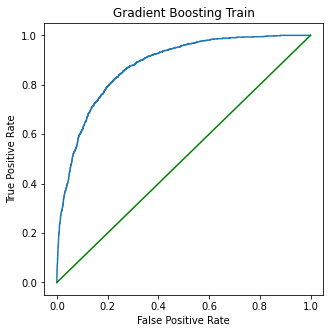

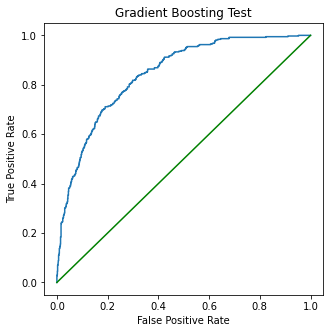

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

mdl_gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators = 250 ,max_depth = 2, random_state = 42)
mdl_gb.fit(X_train, y_train.values.ravel())
ypred_train_gb = mdl_gb.predict(X_train)
y_pred_test_gb = mdl_gb.predict(X_test)

y_proba_train_gb = mdl_gb.predict_proba(X_train)
y_proba_test_gb = mdl_gb.predict_proba(X_test)

print('Train F1-Score:', f1_score(y_train, ypred_train_gb))
print('Test F1-Score:', f1_score(y_test, y_pred_test_gb))

plot_sklearn_roc_curve(y_train, y_proba_train_gb[:, 1], 'Gradient Boosting Train')
plot_sklearn_roc_curve(y_test, y_proba_test_gb[:, 1], 'Gradient Boosting Test')

# Optimizing the Gradient Boosting Parameters Using GridSearch

In [16]:
params = {'max_depth':[2,3,5,7,10] , 'n_estimators': [30,50,100,260,500], 'learning_rate': [10e-4, 10e-3, 10e-2, 0.1, 0.5]}
grid_search = GridSearchCV(GradientBoostingClassifier(random_state = 42), params, cv = 5, n_jobs = -1) #cv = 5 means 5 fold cross validation

grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.1, 0.5],
                         'max_depth': [2, 3, 5, 7, 10],
                         'n_estimators': [30, 50, 100, 260, 500]})

In [17]:
grid_search.best_estimator_

GradientBoostingClassifier(max_depth=2, random_state=42)

# Using Stratified K-Fold
All the steps are the same as the previous model, with only slight change to the name of dictionary and selecting the new model.


In [18]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

gradient_boosting_kfold_scores = {'f1_score_train':[], 'f1_score_test': [],
                              'acc_score_train':[], 'acc_score_test': [],
                              'auc_score_train':[], 'auc_score_test': []}

f1_score_train = []
f1_score_test = []

for train_index, test_index in skf.split(X,y):
    
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    mdl_gb.fit(X1_train, y1_train.values.ravel())
    ypred_train_gb = mdl_gb.predict(X1_train)
    y_pred_test_gb = mdl_gb.predict(X1_test)

    gradient_boosting_kfold_scores.get('f1_score_train').append(f1_score(y1_train, ypred_train_gb))
    gradient_boosting_kfold_scores.get('f1_score_test').append(f1_score(y1_test, y_pred_test_gb))
    
    gradient_boosting_kfold_scores.get('acc_score_train').append(accuracy_score(y1_train, ypred_train_gb))
    gradient_boosting_kfold_scores.get('acc_score_test').append(accuracy_score(y1_test, y_pred_test_gb))
    
    gradient_boosting_kfold_scores.get('auc_score_train').append(roc_auc_score(y1_train, ypred_train_gb))
    gradient_boosting_kfold_scores.get('auc_score_test').append(roc_auc_score(y1_test, y_pred_test_gb))

gradient_boosting_kfold_scores['f1_score_train'] = np.array(gradient_boosting_kfold_scores.get('f1_score_train')).mean()
gradient_boosting_kfold_scores['f1_score_test'] = np.array(gradient_boosting_kfold_scores.get('f1_score_test')).mean()
gradient_boosting_kfold_scores['acc_score_train'] = np.array(gradient_boosting_kfold_scores.get('acc_score_train')).mean()
gradient_boosting_kfold_scores['acc_score_test'] = np.array(gradient_boosting_kfold_scores.get('acc_score_test')).mean()
gradient_boosting_kfold_scores['auc_score_train'] = np.array(gradient_boosting_kfold_scores.get('auc_score_train')).mean()
gradient_boosting_kfold_scores['auc_score_test'] = np.array(gradient_boosting_kfold_scores.get('auc_score_test')).mean()

# Model 3 (OPTIONAL): Support Vector Machine
In this model, we take into account three parameters, `C`, `gamma`, and `kernel`

In [19]:
from sklearn.svm import SVC
svc = SVC(C=1000, gamma=0.0001, kernel='rbf')
svc.fit(X_train, y_train.values.ravel())
  
ypred_train_svc = svc.predict(X_train)
y_pred_test_svc = svc.predict(X_test)

print('Train F1-Score:', f1_score(y_train, ypred_train_svc))
print('Test F1-Score:', f1_score(y_test, y_pred_test_svc))

Train F1-Score: 0.5831452219714072
Test F1-Score: 0.5633383010432191


# Optimizing the Support Vector Machine (Classifier) Parameters Using GridSearch

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ...................C=0.1, gamma=100, kernel=rbf; total time=   1.5s
[CV 2/5] END ...................C=0.1, gamma=100, kernel=rbf; total time=   1.5s
[CV 3/5] END ...................C=0.1, gamma=100, kernel=rbf; total time=   1.5s
[CV 4/5] END ...................C=0.1, gamma=100, kernel=rbf; total time=   1.5s
[CV 5/5] END ...................C=0.1, gamma=100, kernel=rbf; total time=   1.5s
[CV 1/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   1.9s
[CV 2/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   2.2s
[CV 3/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   2.3s
[CV 4/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   1.9s
[CV 5/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   1.9s
[CV 1/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV 2/5] END .....................C=0.1, gamma=

[CV 2/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 3/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 4/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 5/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 1/5] END ...................C=100, gamma=100, kernel=rbf; total time=   2.1s
[CV 2/5] END ...................C=100, gamma=100, kernel=rbf; total time=   2.3s
[CV 3/5] END ...................C=100, gamma=100, kernel=rbf; total time=   1.8s
[CV 4/5] END ...................C=100, gamma=100, kernel=rbf; total time=   2.0s
[CV 5/5] END ...................C=100, gamma=100, kernel=rbf; total time=   1.7s
[CV 1/5] END ....................C=100, gamma=10, kernel=rbf; total time=   2.0s
[CV 2/5] END ....................C=100, gamma=10, kernel=rbf; total time=   2.2s
[CV 3/5] END ....................C=100, gamma=10, kernel=rbf; total time=   2.1s
[CV 4/5] END ...............

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [21]:
grid.best_estimator_

SVC(C=100, gamma=0.001)

# Using Stratified K-Fold
All the steps are the same as the previous model, with only slight change to the name of dictionary and selecting the new model.


In [22]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

svc_kfold_scores = {'f1_score_train':[], 'f1_score_test': [],
                              'acc_score_train':[], 'acc_score_test': [],
                              'auc_score_train':[], 'auc_score_test': []}

f1_score_train = []
f1_score_test = []

for train_index, test_index in skf.split(X,y):
    
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    svc.fit(X1_train, y1_train.values.ravel())
    ypred_train_gb = svc.predict(X1_train)
    y_pred_test_gb = svc.predict(X1_test)

    svc_kfold_scores.get('f1_score_train').append(f1_score(y1_train, ypred_train_gb))
    svc_kfold_scores.get('f1_score_test').append(f1_score(y1_test, y_pred_test_gb))
    
    svc_kfold_scores.get('acc_score_train').append(accuracy_score(y1_train, ypred_train_gb))
    svc_kfold_scores.get('acc_score_test').append(accuracy_score(y1_test, y_pred_test_gb))
    
    svc_kfold_scores.get('auc_score_train').append(roc_auc_score(y1_train, ypred_train_gb))
    svc_kfold_scores.get('auc_score_test').append(roc_auc_score(y1_test, y_pred_test_gb))

svc_kfold_scores['f1_score_train'] = np.array(svc_kfold_scores.get('f1_score_train')).mean()
svc_kfold_scores['f1_score_test'] = np.array(svc_kfold_scores.get('f1_score_test')).mean()
svc_kfold_scores['acc_score_train'] = np.array(svc_kfold_scores.get('acc_score_train')).mean()
svc_kfold_scores['acc_score_test'] = np.array(svc_kfold_scores.get('acc_score_test')).mean()
svc_kfold_scores['auc_score_train'] = np.array(svc_kfold_scores.get('auc_score_train')).mean()
svc_kfold_scores['auc_score_test'] = np.array(svc_kfold_scores.get('auc_score_test')).mean()

# Model 4 (OPTIONAL): Deep Neural Networks
In this model, we take into account three parameters, `activation`, `early_stopping`, `hidden_layer_sizes`, `learning_rate_init`, and `max_iter`.<br/>
After using the GridSearch, we found that a neural network with 5 hidden layers, with each layer having 300 nodes are the best among the GridSearch parameters

Train F1-Score for Neural Network (5 layers with 300 nodes each): 0.6053726825576995
Test F1-Score for Neural Network (5 layers with 300 nodes each): 0.5653495440729484
Train F1-Score for Neural Network (5 layers with 300 nodes each): 0.6053726825576995
Test F1-Score for Neural Network (5 layers with 300 nodes each): 0.5653495440729484


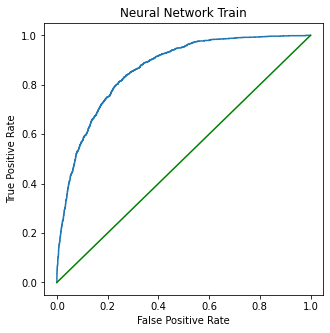

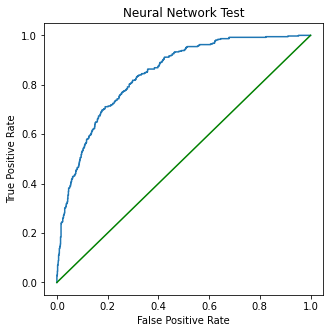

In [23]:
from sklearn.neural_network import MLPClassifier
neural_network = MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(300, 300, 300, 300, 300),
              learning_rate_init=0.0001, max_iter=300, random_state=42)
neural_network.fit(X_train, y_train.values.ravel())

  
ypred_train_nn = neural_network.predict(X_train)
y_pred_test_nn = neural_network.predict(X_test)


print('Train F1-Score for Neural Network (5 layers with 300 nodes each):', f1_score(y_train, ypred_train_nn))
print('Test F1-Score for Neural Network (5 layers with 300 nodes each):', f1_score(y_test, y_pred_test_nn))

y_proba_train_nn = neural_network.predict_proba(X_train)
y_proba_test_nn = neural_network.predict_proba(X_test)

print('Train F1-Score for Neural Network (5 layers with 300 nodes each):', f1_score(y_train, ypred_train_nn))
print('Test F1-Score for Neural Network (5 layers with 300 nodes each):', f1_score(y_test, y_pred_test_nn))


plot_sklearn_roc_curve(y_train, y_proba_train_nn[:, 1], 'Neural Network Train')
plot_sklearn_roc_curve(y_test, y_proba_test_gb[:, 1], 'Neural Network Test')

# Optimizing the Neural Network Parameters Using GridSearch

In [24]:
from sklearn.model_selection import GridSearchCV

GRID = [
    {'solver': ['adam'],
     'learning_rate_init': [0.0001],
     'max_iter': [300],
     'hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
     'activation': ['logistic', 'tanh', 'relu'],
     'alpha': [0.0001, 0.001, 0.005],
     'early_stopping': [True, False]
     }
]


grid_search = GridSearchCV(MLPClassifier(random_state = 42), param_grid=GRID, 
                            n_jobs=-1, cv=5)

grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'activation': ['logistic', 'tanh', 'relu'],
                          'alpha': [0.0001, 0.001, 0.005],
                          'early_stopping': [True, False],
                          'hidden_layer_sizes': [(500, 400, 300, 200, 100),
                                                 (400, 400, 400, 400, 400),
                                                 (300, 300, 300, 300, 300),
                                                 (200, 200, 200, 200, 200)],
                          'learning_rate_init': [0.0001], 'max_iter': [300],
                          'solver': ['adam']}])

In [25]:
grid.best_estimator_

SVC(C=100, gamma=0.001)

# Using Stratified K-Fold
All the steps are the same as the previous model, with only slight change to the name of dictionary and selecting the new model.


In [26]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

neural_network_kfold_scores = {'f1_score_train':[], 'f1_score_test': [],
                              'acc_score_train':[], 'acc_score_test': [],
                              'auc_score_train':[], 'auc_score_test': []}

f1_score_train = []
f1_score_test = []

for train_index, test_index in skf.split(X,y):
    
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    neural_network.fit(X1_train, y1_train.values.ravel())
    ypred_train_gb = neural_network.predict(X1_train)
    y_pred_test_gb = neural_network.predict(X1_test)

    neural_network_kfold_scores.get('f1_score_train').append(f1_score(y1_train, ypred_train_gb))
    neural_network_kfold_scores.get('f1_score_test').append(f1_score(y1_test, y_pred_test_gb))
    
    neural_network_kfold_scores.get('acc_score_train').append(accuracy_score(y1_train, ypred_train_gb))
    neural_network_kfold_scores.get('acc_score_test').append(accuracy_score(y1_test, y_pred_test_gb))
    
    neural_network_kfold_scores.get('auc_score_train').append(roc_auc_score(y1_train, ypred_train_gb))
    neural_network_kfold_scores.get('auc_score_test').append(roc_auc_score(y1_test, y_pred_test_gb))

neural_network_kfold_scores['f1_score_train'] = np.array(neural_network_kfold_scores.get('f1_score_train')).mean()
neural_network_kfold_scores['f1_score_test'] = np.array(neural_network_kfold_scores.get('f1_score_test')).mean()
neural_network_kfold_scores['acc_score_train'] = np.array(neural_network_kfold_scores.get('acc_score_train')).mean()
neural_network_kfold_scores['acc_score_test'] = np.array(neural_network_kfold_scores.get('acc_score_test')).mean()
neural_network_kfold_scores['auc_score_train'] = np.array(neural_network_kfold_scores.get('auc_score_train')).mean()
neural_network_kfold_scores['auc_score_test'] = np.array(neural_network_kfold_scores.get('auc_score_test')).mean()

# Comparing the Models with Different Metrics
In the last part, we put the results of different metrics of our models into a dataframe to better illustrate the efficiency of our models

In [27]:
columns = ['Model', 'Train F1-score', 'Test F1-score', 'Train Accuracy', 'Test Accuracy', 'Train AUC', 'Test AUC']
result_df = pd.DataFrame(columns=columns)

result_df.loc[len(result_df.index)] = ['Random Forest', random_forest_kfold_scores.get('f1_score_train'), random_forest_kfold_scores.get('f1_score_test'), random_forest_kfold_scores.get('acc_score_train'), random_forest_kfold_scores.get('acc_score_test'), random_forest_kfold_scores.get('auc_score_train'), random_forest_kfold_scores.get('auc_score_test')]
result_df.loc[len(result_df.index)] = ['Gradient Boosting', gradient_boosting_kfold_scores.get('f1_score_train'), gradient_boosting_kfold_scores.get('f1_score_test'), gradient_boosting_kfold_scores.get('acc_score_train'), gradient_boosting_kfold_scores.get('acc_score_test'), gradient_boosting_kfold_scores.get('auc_score_train'), gradient_boosting_kfold_scores.get('auc_score_test')]
result_df.loc[len(result_df.index)] = ['Support Vector Machine', svc_kfold_scores.get('f1_score_train'), svc_kfold_scores.get('f1_score_test'), svc_kfold_scores.get('acc_score_train'), svc_kfold_scores.get('acc_score_test'), svc_kfold_scores.get('auc_score_train'), svc_kfold_scores.get('auc_score_test')]
result_df.loc[len(result_df.index)] = ['Neural Network', neural_network_kfold_scores.get('f1_score_train'), neural_network_kfold_scores.get('f1_score_test'), neural_network_kfold_scores.get('acc_score_train'), neural_network_kfold_scores.get('acc_score_test'), neural_network_kfold_scores.get('auc_score_train'), neural_network_kfold_scores.get('auc_score_test')]


In [28]:
result_df

,Model,Train F1-score,Test F1-score,Train Accuracy,Test Accuracy,Train AUC,Test AUC
0,Random Forest,0.739132,0.576511,0.872387,0.799230,0.811354,0.708704
1,Gradient Boosting,0.634124,0.582026,0.825248,0.800506,0.743954,0.712302
2,Support Vector Machine,0.745534,0.542877,0.871961,0.769700,0.819228,0.688428
3,Neural Network,0.519499,0.498427,0.793791,0.783895,0.676235,0.665617
